# Case study Chile 2017

This notebook reproduces the plots and the analysis as displayed in the WildFire paper by Lüthi et al.

This notebook is pre-calculated. In order to do the calculations yourself please downlaod and install CLIMADA which is available at https://github.com/CLIMADA-project/climada_python

Please refer to details on installation and model set-up to
https://climada-python.readthedocs.io/en/v0.1.0/install.html

# Input data:

Data on past wildfire activity can be downloaded at https://firms.modaps.eosdis.nasa.gov/download/
Please select data for Chile and January 2017 as time horizon.
Data on exposure and vulnerability is available directly through CLIMADA (or via APIs)

# Import climada.WildFire() and required libraries

In [2]:
import os
import sys
sys.path.append('/Users/sam/Documents/GitHub/climada_python')
from climada.hazard.wildfire import WildFire
from climada.hazard import Centroids

from climada.entity.exposures.base import Exposures
from climada.entity.exposures.litpop import LitPop
from climada.entity.impact_funcs.wildfire import ImpfWildfire
from climada.entity.impact_funcs import ImpactFuncSet

from climada.engine import Impact

from climada.util.constants import ONE_LAT_KM
from climada.util.dates_times import date_to_str
from climada.util.scalebar_plot import scale_bar
import climada.util.plot as u_plot

from matplotlib import colors
import numpy as np
import pandas as pd
import geopandas as gp
import pickle
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from copy import copy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import LogNorm

# Set up hazard (wildfire)

We load the FIRMS data as downloaded, and map it onto a regular grid of centroids.

In [3]:
""" Data Paths """
DATA_path = "/Users/sam/OneDrive - ETH Zurich/WCR/Projects/Bush_fire/Data/"
DIR_MODIS = os.path.join(DATA_path, "Chile_2017/chile_2017_fire_archive_M6_116596.csv")


""" Define region """
lat_max = -32
lat_min = -38
lon_max = -69.816
lon_min = -73.5

""" Hazard calcs """
# load data
firms = pd.read_csv(DIR_MODIS)
set_zoom = [lon_min, lat_min, lon_max, lat_max]
res = 4./ONE_LAT_KM # resolution is set to 4 km

# set up centroid grid
centr_zoom = Centroids()
centr_zoom.set_raster_from_pnt_bounds(set_zoom, res)

# calculate hazard
wf_main = WildFire()
wf_main.set_hist_fire_FIRMS(firms,centroids=centr_zoom)
wf_main.combine_fires()

2021-05-28 15:39:47,935 - climada.hazard.wildfire - INFO - Remaining fires to identify: 9322.
2021-05-28 15:39:48,821 - climada.hazard.wildfire - INFO - Remaining fires to identify: 4.
2021-05-28 15:39:48,870 - climada.hazard.wildfire - INFO - Remaining fires to identify: 0.
2021-05-28 15:39:49,433 - climada.hazard.wildfire - INFO - Computing intensity of 69 fires.
2021-05-28 15:39:50,162 - climada.hazard.wildfire - INFO - Returning 53 fires that impacted the defined centroids.
2021-05-28 15:39:50,320 - climada.hazard.wildfire - INFO - The merged event has event_id 55


## Set up exposure (LitPop)

We load LitPop and cut it to the defined region

In [4]:
""" Load exposure """
chl = LitPop()
chl.set_country('CHL', res_arcsec=120, reference_year=2017) # this might take a minute while

# cut to defined region
chl.gdf = chl.gdf[chl.gdf['latitude']>lat_min]
chl.gdf = chl.gdf[chl.gdf['latitude']<lat_max]
chl.gdf = chl.gdf[chl.gdf['longitude']>lon_min]
chl.gdf = chl.gdf[chl.gdf['longitude']<lon_max]
chl.set_geometry_points()
chl.check()

2021-05-28 16:07:35,419 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-05-28 16:07:35,420 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-05-28 16:07:35,421 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-05-28 16:07:35,422 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-05-28 16:07:35,424 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-05-28 16:07:37,422 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 120 arcsec.
2021-05-28 16:07:44,481 - climada.entity.exposures.gpw_import - INFO - Reference year: 2017. Using nearest available year for GWP population data: 2015
2021-05-28 16:07:44,483 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.13
2021-05-28 16:08:05,072 - climada.util.finance - INFO - GDP CHL 2014: 2.605e+11.
2021-05-28 16:08:05,501 - climada.util.finance -

/Users/sam/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/geopandas/geodataframe.py:167: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


2021-05-28 16:08:13,534 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2021-05-28 16:08:13,535 - climada.entity.exposures.base - INFO - category_id not set.
2021-05-28 16:08:13,536 - climada.entity.exposures.base - INFO - cover not set.
2021-05-28 16:08:13,537 - climada.entity.exposures.base - INFO - deductible not set.
2021-05-28 16:08:13,538 - climada.entity.exposures.base - INFO - centr_ not set.


## Set up vulnerability and calculate damages

In [5]:
# set up impact function
if_wf = ImpfWildfire()
if_wf.set_default_FIRMS(i_half=409.5) # as calibrated for 4 km resolution
if_wf.check()
impf_ = ImpactFuncSet()
impf_.append(if_wf)

# Impact
imp = Impact()
imp.calc(chl, impf_, wf_main, save_mat=True)

2021-05-28 16:09:14,533 - climada.entity.exposures.base - INFO - Matching 10340 exposures with 17304 centroids.
2021-05-28 16:09:14,545 - climada.engine.impact - INFO - Calculating damage for 10302 assets (>0) and 1 events.
2021-05-28 16:09:14,546 - climada.engine.impact - INFO - Missing exposures impact functions for hazard if_WFsingle. Using impact functions in if_.


## Plot results

In [9]:
# plotting functions
def plot_haz_hexbin(haz, palette, **kwargs):
    value_haz = haz.intensity.toarray() #np.array of intensity
    geo_coord_haz = np.stack([haz.centroids.lat, haz.centroids.lon], axis=1)
    var_name_haz = 'Intensity (K)'
    title = ''
    BUFFER = 0.01
    ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()),
                             squeeze=True, sharex=False, sharey=True)
    ax = u_plot.geo_bin_from_array(value_haz, geo_coord_haz, var_name_haz, title,
                              pop_name=True, buffer=BUFFER, extend='neither',
                              proj=ccrs.PlateCarree(), axes=None, cmap=palette,
                              gridsize=100, vmin=200, vmax=500)
    scale_bar(ax, (0.80, 0.10), 50)
    
def plot_exp_hexbin(exp, palette, **kwargs):

    value_exp = exp.gdf.value.values #np.array exposure values
    geo_coord_exp = np.stack([exp.gdf.latitude.values, exp.gdf.longitude.values], axis=1)
    var_name_exp = 'Value (USD)'
    title = ''
    BUFFER = 0.01
    ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()),
                             squeeze=True, sharex=False, sharey=True)
    ax = u_plot.geo_bin_from_array(value_exp, geo_coord_exp, var_name_exp, title,
                              pop_name=True, buffer=BUFFER, extend='neither',
                              proj=ccrs.PlateCarree(), axes=None, cmap=palette,
                              gridsize=100, norm=LogNorm(vmin=1, vmax=10**11))
    scale_bar(ax, (0.80, 0.10), 50)
    
def plot_imp_hexbin(imp, exp, palette, **kwargs):

    value_imp = imp.imp_mat.toarray()
    geo_coord_imp = np.stack([exp.gdf.latitude.values, exp.gdf.longitude.values], axis=1)
    var_name_imp = 'Value (USD)'
    title = ''
    BUFFER = 0.01
    ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()),
                             squeeze=True, sharex=False, sharey=True)
    ax = u_plot.geo_bin_from_array(value_imp, geo_coord_imp, var_name_imp, title,
                              pop_name=True, buffer=BUFFER, extend='neither',
                              proj=ccrs.PlateCarree(), axes=None, gridsize=100,
                              cmap=palette, norm=LogNorm(vmin=10, vmax=10**8))
    scale_bar(ax, (0.80, 0.10), 50)
        

# define color maps
pal_exp = copy(plt.get_cmap('BuPu'))
pal_haz = copy(plt.get_cmap('YlOrRd'))
pal_haz.set_under('white', 1.0) 
pal_imp = copy(plt.get_cmap('magma_r'))
pal_imp.set_under('white', 1.0) 


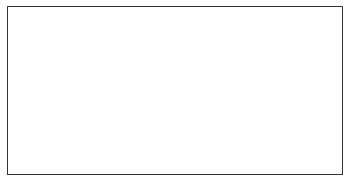

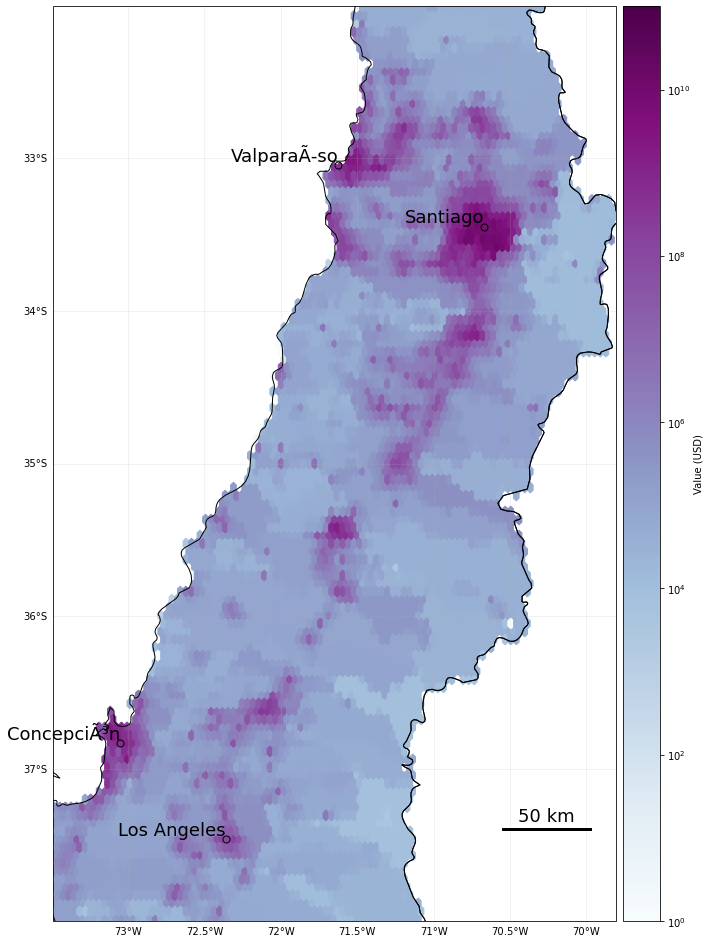

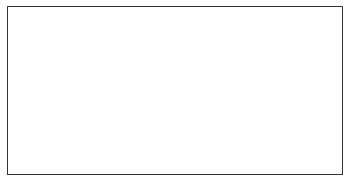

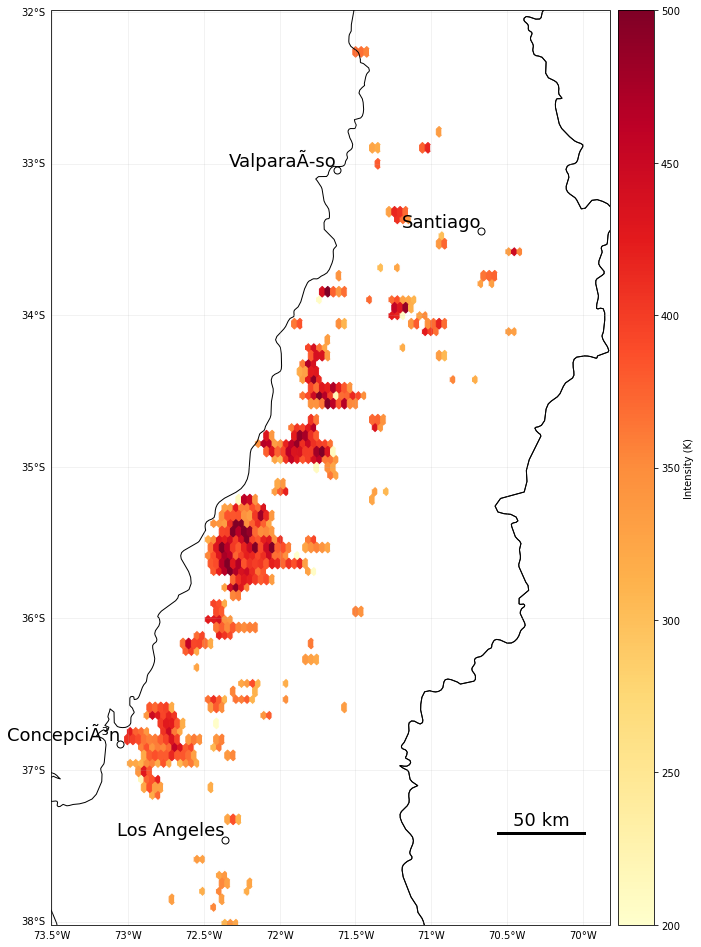

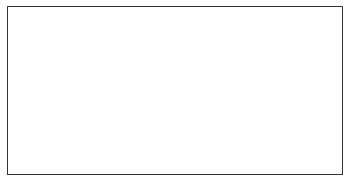

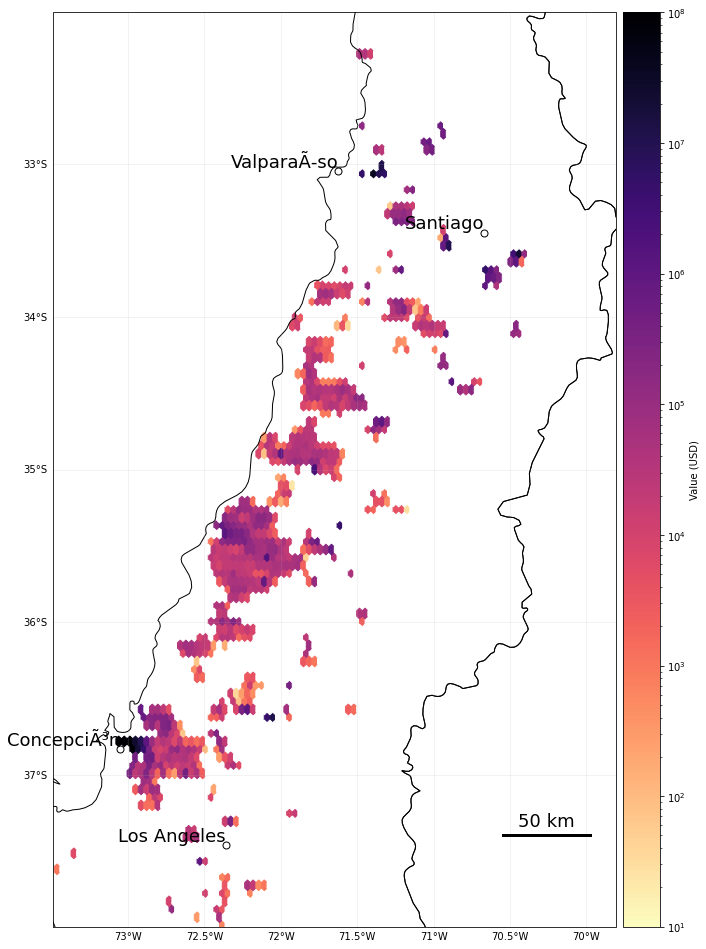

In [10]:
# make plots
plot_exp_hexbin(chl, pal_exp)
plot_haz_hexbin(wf_main, pal_haz)
plot_imp_hexbin(imp, chl, pal_imp)